### Load Stretched Reps and Inverted Images of stretched reps

In [87]:
from pytorch_lightning import utilities as pl_utils
from pytorch_lightning.trainer.trainer import Trainer
from pytorch_lightning.plugins import DDPPlugin, DataParallelPlugin
from torchvision import transforms

import torch
import torch.nn as nn
from functools import partial
import argparse
import pathlib
import numpy as np
from PIL import Image
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt

import os, sys, glob
sys.path.append('..')
sys.path.append('../deep-learning-base')
for p in glob.glob('../deep-learning-base/*'):
    if os.path.isdir(p):
        sys.path.append(p)

from training import LitProgressBar
import architectures as arch
from attack.callbacks import AdvCallback
from architectures.callbacks import LightningWrapper
from equivariance.stretched_inversion_callback import StretchedInvertedRepWrapper
from torch.utils.data import Dataset, DataLoader
from equivariance.utils import wrap_into_dataloader, DatasetFromImagesPaths
from datasets.data_modules import DATA_MODULES
from datasets.dataset_metadata import DATASET_PARAMS
from human_nn_alignment.utils import initialize_seed, LOSSES_MAPPING
from human_nn_alignment.save_inverted_reps import \
    save_tensor_images, get_classes_names, save_tensor_reps
from equivariance.callbacks import VectorCallback

In [35]:
seed = 2
devices = 1
num_nodes = 1
data_path = '/NS/twitter_archive/work/vnanda/data'
classes_names = get_classes_names(dataset, data_path)
strategy = DataParallelPlugin() if devices > 1 else None
## See: https://github.com/Lightning-AI/lightning/issues/7550
## Seems like DDP does not work in Jupyter, use DP for multi-GPU inference

In [73]:
def sanity_check_saved_reps(images_paths, reps_path, m2):
    ### This sanity check will not pass for things generated with DDP
    if os.path.exists(reps_path):
        reps = torch.load(reps_path, map_location='cpu')
    else:
        reps = None
    dl = DataLoader(DatasetFromImagesPaths(images_paths), 
                    batch_size=batch_size, num_workers=30, pin_memory=True)
    trainer = Trainer(accelerator='gpu', devices=devices,
                      num_nodes=num_nodes, strategy=strategy, 
                      log_every_n_steps=1, auto_select_gpus=True, 
                      deterministic=True, max_epochs=1,
                      check_val_every_n_epoch=1, num_sanity_val_steps=0,
                      callbacks=[LitProgressBar(['loss'])])
    _, fresh_reps, _ = trainer.predict(m2, dataloaders=[dl])
    
    if reps is None:    reps = torch.zeros_like(fresh_reps)
    sanity_check = torch.isclose(torch.linalg.norm(reps-fresh_reps), torch.tensor(0.))
    
    return reps if sanity_check else fresh_reps

In [74]:
def analyze(model1, m1, model2, m2, dataset, classes_names, vector_class_idx, 
            inversion_loss, append_path, seed_type):
    stretch_to_scatter = {}
    stretch_to_hyperplane_acc = {}
    stretch_to_hyperplane_sim = {}
    stretch_to_gt_sim = {}
    for stretch_factor in np.linspace(0., 10., 20):
        base_path = f'./results/generated_images/{dataset}/'\
            f'{dataset}_{model1}_{inversion_loss}_stretch_{stretch_factor:.2f}_{classes_names[vector_class_idx]}'
        if append_path:
            base_path += f'_{append_path}'
        if not os.path.exists(base_path):
            continue

        images_ir = sorted(glob.glob(f'{base_path}/result/*.png'), 
                           key=lambda x: int(x.split('/')[-1].split('_')[0]))
        images_og = sorted(glob.glob(f'{base_path}/target/*.png'), 
                           key=lambda x: int(x.split('/')[-1].split('_')[0]))

        ## these reps are not reliable when generated with DDP -- if sanity checks aren't passed, 
        ## then reps must be regenerated
        reps_ir_paths = f'{base_path}/result/{model2}_latent_{seed_type}.pth'
        reps_ir = sanity_check_saved_reps(images_ir, reps_ir_paths, m2)
        reps_og_paths = f'{base_path}/target/{model2}_latent_{seed_type}.pth'
        reps_og = sanity_check_saved_reps(images_og, reps_og_paths, m2)

        scatter = reps_ir - reps_og

        final_layer = list(m2.model.named_children())[-1][1]
        gt_vector = final_layer.weight[vector_class_idx]
        gt_vector = gt_vector/torch.linalg.norm(gt_vector, ord=2)

        clf = LogisticRegression(max_iter=1000)
        X = np.concatenate((reps_ir.numpy(), reps_og.numpy()))
        Y = np.concatenate((np.ones(len(reps_ir)), np.zeros(len(reps_og))))
        clf.fit(X, Y)
        stretch_to_hyperplane_acc[stretch_factor] = clf.score(X, Y)

        hyperplane_vector_sim = nn.CosineSimilarity(dim=1)(
            torch.from_numpy(clf.coef_).to(gt_vector.device), 
            gt_vector.reshape(1, *gt_vector.shape))
        stretch_to_hyperplane_sim[stretch_factor] = hyperplane_vector_sim

        # compare with ground truth
        gt_sim = nn.CosineSimilarity(dim=1)(
            torch.stack([gt_vector]*len(scatter)), scatter).detach().cpu()
        stretch_to_gt_sim[stretch_factor] = gt_sim

        # do pairwise similarities on scatter vectors
        scatter_norms = torch.linalg.norm(scatter, ord=2, dim=1).reshape(scatter.shape[0], 1)
        div = torch.mm(scatter_norms, scatter_norms.T)
        new_sim_matrix = torch.mm(scatter, scatter.T)/torch.max(div, torch.ones_like(div) * 1e-08)
        mask = torch.triu(torch.ones_like(new_sim_matrix), diagonal=1).bool()
        new_sim_matrix = new_sim_matrix[mask]
        stretch_to_scatter[stretch_factor] = new_sim_matrix
    
    return stretch_to_scatter, stretch_to_hyperplane_acc, stretch_to_hyperplane_sim, stretch_to_gt_sim

In [93]:
def visualize(model1, dataset, inversion_loss, classes_names, vector_class_idx, append_path, num_images=10):
    base_path = f'./results/generated_images/{dataset}/'\
        f'{dataset}_{model1}_{inversion_loss}_stretch_0.00_{classes_names[vector_class_idx]}'
    if append_path:
        base_path += f'_{append_path}'
    
    image_names = [x.split('/')[-1] for x in glob.glob(f'{base_path}/target/*.png')][:num_images]
    for image_name in image_names:
        images = [np.array(Image.open(f'{base_path}/target/{image_name}'))]
        headings = ['Target']
        for stretch_factor in np.linspace(0., 10., 20):
            img_path = f'./results/generated_images/{dataset}/'\
                f'{dataset}_{model1}_{inversion_loss}_stretch_'\
                f'{stretch_factor:.2f}_{classes_names[vector_class_idx]}'
            if append_path:
                img_path += f'_{append_path}'
            
            if not os.path.exists(img_path):
                continue
            
            headings.append(r'$\lambda = $' + f'{stretch_factor:.2f}')
            images.append(np.array(Image.open(f'{img_path}/result/{image_name}')))
        
        columns = len(images)
        rows = 1
        fig = plt.figure(figsize=(10,2))
        for i in range(1, columns * rows + 1):
            ax = fig.add_subplot(rows, columns, i)
            # ax.axis('off')
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])
            ax.xaxis.set_ticklabels([])
            ax.yaxis.set_ticklabels([])
            ax.imshow(images[i-1] if images[i-1].shape[-1] == 3 else \
                images[i-1].reshape((images[i-1].shape[0], images[i-1].shape[1])), 
                cmap='viridis' if images[i-1].shape[-1] == 3 else 'gray', interpolation='bilinear')
            ax.set_title(headings[i-1])
        fig.suptitle(f'Stretched to be {classes_names[vector_class_idx]}')
        plt.show()

### ImageNet; m1 = robust resnet18, m2 = robust resnet50

In [57]:
dataset = 'imagenet'
model1 = 'resnet18'
model2 = 'resnet50'
batch_size = 100
inversion_loss = 'reg_free'
checkpoint1_path = '/NS/robustness_1/work/vnanda/CKA-Centered-Kernel-Alignment/checkpoints/imagenet/'\
                    'resnet18/robust/l2/eps3/iters7da_True/checkpoint_rand_seed_1.pt.best'
checkpoint2_path = '/NS/robustness_2/work/vnanda/adv-robustness/logs/robust_imagenet/eps3/resnet-50-l2-eps3.ckpt'
seed_type = 'super-noise'
vector_type = 'class_logit'
vector_class_idx = 10
append_path = 'robl2eps3_seed_1'

In [58]:
m1 = arch.create_model(model1, dataset, pretrained=True, 
                       checkpoint_path=checkpoint1_path, seed=seed, 
                       callback=partial(LightningWrapper, 
                                        inference_kwargs={'with_latent': True}, 
                                        dataset_name=dataset))
m2 = arch.create_model(model2, dataset, pretrained=True, 
                       checkpoint_path=checkpoint2_path, seed=seed, 
                       callback=partial(LightningWrapper, 
                                        inference_kwargs={'with_latent': True}, 
                                        dataset_name=dataset))

Global seed set to 2
Global seed set to 2


In [59]:
stretch_to_scatter, stretch_to_hyperplane_acc, stretch_to_hyperplane_sim, stretch_to_gt_sim = \
    analyze(model1, m1, model2, m2, dataset, classes_names, 
        vector_class_idx, inversion_loss, append_path, seed_type)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

In [61]:
stretch_to_hyperplane_acc

{0.0: 1.0,
 0.5263157894736842: 1.0,
 1.0526315789473684: 1.0,
 1.5789473684210527: 1.0,
 2.1052631578947367: 1.0,
 2.631578947368421: 1.0,
 3.1578947368421053: 1.0,
 3.6842105263157894: 1.0,
 4.2105263157894735: 1.0,
 4.7368421052631575: 1.0,
 5.263157894736842: 1.0,
 5.789473684210526: 1.0,
 6.315789473684211: 1.0,
 6.842105263157895: 1.0,
 7.368421052631579: 1.0,
 7.894736842105263: 1.0,
 8.421052631578947: 1.0}

In [62]:
{k:v.item() for k,v in stretch_to_hyperplane_sim.items()}

{0.0: 0.03899941369150065,
 0.5263157894736842: 0.0392855698207002,
 1.0526315789473684: 0.039543763146834714,
 1.5789473684210527: 0.03977937985659376,
 2.1052631578947367: 0.04006543174995268,
 2.631578947368421: 0.04031124025255166,
 3.1578947368421053: 0.04056126993836643,
 3.6842105263157894: 0.0408754704842581,
 4.2105263157894735: 0.041074878333219794,
 4.7368421052631575: 0.04137731708037222,
 5.263157894736842: 0.041638897579040116,
 5.789473684210526: 0.041957391368285184,
 6.315789473684211: 0.04220228293180438,
 6.842105263157895: 0.04244086240108287,
 7.368421052631579: 0.042699128683001,
 7.894736842105263: 0.042968294991610166,
 8.421052631578947: 0.04321833045990723}

In [63]:
for k, v in stretch_to_scatter.items():
    print (f'Stretch Factor: {k}, {torch.sum(v>0, dim=0)/v.shape[0]}, {torch.mean(v)}')

Stretch Factor: 0.0, 1.0, 0.6543107032775879
Stretch Factor: 0.5263157894736842, 1.0, 0.6542485952377319
Stretch Factor: 1.0526315789473684, 1.0, 0.6541894674301147
Stretch Factor: 1.5789473684210527, 1.0, 0.6541346907615662
Stretch Factor: 2.1052631578947367, 1.0, 0.6540709733963013
Stretch Factor: 2.631578947368421, 1.0, 0.654007077217102
Stretch Factor: 3.1578947368421053, 1.0, 0.6539468169212341
Stretch Factor: 3.6842105263157894, 1.0, 0.6538934707641602
Stretch Factor: 4.2105263157894735, 1.0, 0.653836190700531
Stretch Factor: 4.7368421052631575, 1.0, 0.6537867784500122
Stretch Factor: 5.263157894736842, 1.0, 0.6537283658981323
Stretch Factor: 5.789473684210526, 1.0, 0.6536757946014404
Stretch Factor: 6.315789473684211, 1.0, 0.6536238193511963
Stretch Factor: 6.842105263157895, 1.0, 0.6535682082176208
Stretch Factor: 7.368421052631579, 1.0, 0.6535227298736572
Stretch Factor: 7.894736842105263, 1.0, 0.6534870862960815
Stretch Factor: 8.421052631578947, 1.0, 0.6534485220909119


In [64]:
print ('Similarity of scatter to GT vector')
print ()

for k, v in stretch_to_gt_sim.items():
    print (f'Stretch Factor: {k}, {torch.sum(v>0, dim=0)/v.shape[0]}, {torch.mean(v)}')

Similarity of scatter to GT vector

Stretch Factor: 0.0, 0.754800021648407, 0.02139897830784321
Stretch Factor: 0.5263157894736842, 0.7559999823570251, 0.021635886281728745
Stretch Factor: 1.0526315789473684, 0.7577999830245972, 0.02187485434114933
Stretch Factor: 1.5789473684210527, 0.7598000168800354, 0.022121645510196686
Stretch Factor: 2.1052631578947367, 0.7608000040054321, 0.022366546094417572
Stretch Factor: 2.631578947368421, 0.7623999714851379, 0.0226127952337265
Stretch Factor: 3.1578947368421053, 0.76419997215271, 0.022865403443574905
Stretch Factor: 3.6842105263157894, 0.7657999992370605, 0.023119093850255013
Stretch Factor: 4.2105263157894735, 0.7670000195503235, 0.02337493561208248
Stretch Factor: 4.7368421052631575, 0.7698000073432922, 0.023634180426597595
Stretch Factor: 5.263157894736842, 0.772599995136261, 0.02389717474579811
Stretch Factor: 5.789473684210526, 0.7742000222206116, 0.02416219748556614
Stretch Factor: 6.315789473684211, 0.7753999829292297, 0.024427218362

### ImageNet; m1 = robust resnet50, m2 = robust resnet18

In [60]:
dataset = 'imagenet'
model2 = 'resnet18'
model1 = 'resnet50'
batch_size = 100
inversion_loss = 'reg_free'
checkpoint2_path = '/NS/robustness_1/work/vnanda/CKA-Centered-Kernel-Alignment/checkpoints/imagenet/'\
                    'resnet18/robust/l2/eps3/iters7da_True/checkpoint_rand_seed_1.pt.best'
checkpoint1_path = '/NS/robustness_2/work/vnanda/adv-robustness/logs/robust_imagenet/eps3/resnet-50-l2-eps3.ckpt'
seed_type = 'super-noise'
vector_type = 'class_logit'
vector_class_idx = 10
append_path = 'robl2eps3_seed_1'

m1 = arch.create_model(model1, dataset, pretrained=True, 
                       checkpoint_path=checkpoint1_path, seed=seed, 
                       callback=partial(LightningWrapper, 
                                        inference_kwargs={'with_latent': True}, 
                                        dataset_name=dataset))
m2 = arch.create_model(model2, dataset, pretrained=True, 
                       checkpoint_path=checkpoint2_path, seed=seed, 
                       callback=partial(LightningWrapper, 
                                        inference_kwargs={'with_latent': True}, 
                                        dataset_name=dataset))

Global seed set to 2
Global seed set to 2


In [65]:
stretch_to_scatter, stretch_to_hyperplane_acc, stretch_to_hyperplane_sim, stretch_to_gt_sim = \
    analyze(model1, m1, model2, m2, dataset, classes_names, 
        vector_class_idx, inversion_loss, append_path, seed_type)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

In [69]:
print ('How accurately can hyperplane separate stretched and original reps')
print ('\n'.join([f'{k}: {v}' for k,v in stretch_to_hyperplane_acc.items()]))
print ()
print ('How similar is hyperplane to GT vector')
print ()
print ('\n'.join([f'{k}: {v.item()}' for k,v in stretch_to_hyperplane_sim.items()]))
print ()
print ('Things scattered in the same direction')
print ()
for k, v in stretch_to_scatter.items():
    print (f'Stretch Factor: {k}, {torch.sum(v>0, dim=0)/v.shape[0]}, {torch.mean(v)}')
print ()
print ('Similarity of scatter to GT vector')
print ()
for k, v in stretch_to_gt_sim.items():
    print (f'Stretch Factor: {k}, {torch.sum(v>0, dim=0)/v.shape[0]}, {torch.mean(v)}')

How accurately can hyperplane separate stretched and original reps
0.0: 1.0
0.5263157894736842: 1.0
1.0526315789473684: 1.0
1.5789473684210527: 1.0
2.1052631578947367: 1.0
2.631578947368421: 1.0
3.1578947368421053: 1.0
3.6842105263157894: 1.0
4.2105263157894735: 1.0
4.7368421052631575: 1.0
5.263157894736842: 1.0

How similar is hyperplane to GT vector

0.0: -0.01967297677004193
0.5263157894736842: -0.01963692501719347
1.0526315789473684: -0.019650078667859828
1.5789473684210527: -0.019655628905798774
2.1052631578947367: -0.019631247486825557
2.631578947368421: -0.019618786273732182
3.1578947368421053: -0.01961803917251125
3.6842105263157894: -0.019629549922942798
4.2105263157894735: -0.01961142705702466
4.7368421052631575: -0.01961151834290591
5.263157894736842: -0.01961854825069746

Things scattered in the same direction

Stretch Factor: 0.0, 1.0, 0.5288012623786926
Stretch Factor: 0.5263157894736842, 1.0, 0.52903151512146
Stretch Factor: 1.0526315789473684, 1.0, 0.5292608737945557
St

### ImageNet; m1 = resnet18, m2 = resnet50

In [71]:
dataset = 'imagenet'
model1 = 'resnet18'
model2 = 'resnet50'
batch_size = 100
inversion_loss = 'reg_free'
checkpoint1_path = '/NS/robustness_1/work/vnanda/CKA-Centered-Kernel-Alignment/checkpoints/imagenet/'\
                    'resnet18/robust/l2/eps3/iters7da_True/checkpoint_rand_seed_1.pt.best'
checkpoint2_path = '/NS/robustness_2/work/vnanda/adv-robustness/logs/robust_imagenet/eps3/resnet-50-l2-eps3.ckpt'
seed_type = 'super-noise'
vector_type = 'class_logit'
vector_class_idx = 10
append_path = 'robl2eps3_seed_1_testing'

m1 = arch.create_model(model1, dataset, pretrained=True, 
                       checkpoint_path=checkpoint1_path, seed=seed, 
                       callback=partial(LightningWrapper, 
                                        inference_kwargs={'with_latent': True}, 
                                        dataset_name=dataset))
m2 = arch.create_model(model2, dataset, pretrained=True, 
                       checkpoint_path=checkpoint2_path, seed=seed, 
                       callback=partial(LightningWrapper, 
                                        inference_kwargs={'with_latent': True}, 
                                        dataset_name=dataset))

Global seed set to 2
Global seed set to 2


In [76]:
stretch_to_scatter, stretch_to_hyperplane_acc, stretch_to_hyperplane_sim, stretch_to_gt_sim = \
    analyze(model1, m1, model2, m2, dataset, classes_names, 
        vector_class_idx, inversion_loss, append_path, seed_type)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

In [78]:
print ('How accurately can hyperplane separate stretched and original reps')
print ('\n'.join([f'{k}: {v}' for k,v in stretch_to_hyperplane_acc.items()]))
print ()
print ('How similar is hyperplane to GT vector')
print ()
print ('\n'.join([f'{k}: {v.item()}' for k,v in stretch_to_hyperplane_sim.items()]))
print ()
print ('Things scattered in the same direction')
print ()
for k, v in stretch_to_scatter.items():
    print (f'Stretch Factor: {k}, {torch.sum(v>0, dim=0)/v.shape[0]}, {torch.mean(v)}')
print ()
print ('Similarity of scatter to GT vector')
print ()
for k, v in stretch_to_gt_sim.items():
    print (f'Stretch Factor: {k}, {torch.sum(v>0, dim=0)/v.shape[0]}, {torch.mean(v)}')

How accurately can hyperplane separate stretched and original reps
0.0: 1.0
0.5263157894736842: 1.0
1.0526315789473684: 1.0
1.5789473684210527: 1.0
2.1052631578947367: 1.0
2.631578947368421: 1.0
3.1578947368421053: 1.0
3.6842105263157894: 1.0

How similar is hyperplane to GT vector

0.0: 0.021490992766252996
0.5263157894736842: 0.03527659283711103
1.0526315789473684: 0.05085215806801147
1.5789473684210527: 0.07167085266733872
2.1052631578947367: 0.09744106817350189
2.631578947368421: 0.11626955907408403
3.1578947368421053: 0.1348373817960462
3.6842105263157894: 0.15781920855419831

Things scattered in the same direction

Stretch Factor: 0.0, 1.0, 0.28198111057281494
Stretch Factor: 0.5263157894736842, 1.0, 0.2800266444683075
Stretch Factor: 1.0526315789473684, 1.0, 0.28354009985923767
Stretch Factor: 1.5789473684210527, 1.0, 0.28180569410324097
Stretch Factor: 2.1052631578947367, 1.0, 0.2884436547756195
Stretch Factor: 2.631578947368421, 1.0, 0.2873922884464264
Stretch Factor: 3.157894

### ImageNet; m1 = resnet50, m2 = resnet18

In [77]:
dataset = 'imagenet'
model1 = 'resnet50'
model2 = 'resnet18'
batch_size = 100
inversion_loss = 'reg_free'
checkpoint2_path = '/NS/robustness_1/work/vnanda/CKA-Centered-Kernel-Alignment/checkpoints/imagenet/'\
                    'resnet18/robust/l2/eps3/iters7da_True/checkpoint_rand_seed_1.pt.best'
checkpoint1_path = '/NS/robustness_2/work/vnanda/adv-robustness/logs/robust_imagenet/eps3/resnet-50-l2-eps3.ckpt'
seed_type = 'super-noise'
vector_type = 'class_logit'
vector_class_idx = 10
append_path = 'robl2eps3_seed_1_testing'

m1 = arch.create_model(model1, dataset, pretrained=True, 
                       checkpoint_path=checkpoint1_path, seed=seed, 
                       callback=partial(LightningWrapper, 
                                        inference_kwargs={'with_latent': True}, 
                                        dataset_name=dataset))
m2 = arch.create_model(model2, dataset, pretrained=True, 
                       checkpoint_path=checkpoint2_path, seed=seed, 
                       callback=partial(LightningWrapper, 
                                        inference_kwargs={'with_latent': True}, 
                                        dataset_name=dataset))

Global seed set to 2
Global seed set to 2


In [79]:
stretch_to_scatter, stretch_to_hyperplane_acc, stretch_to_hyperplane_sim, stretch_to_gt_sim = \
    analyze(model1, m1, model2, m2, dataset, classes_names, 
        vector_class_idx, inversion_loss, append_path, seed_type)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

In [80]:
print ('How accurately can hyperplane separate stretched and original reps')
print ('\n'.join([f'{k}: {v}' for k,v in stretch_to_hyperplane_acc.items()]))
print ()
print ('How similar is hyperplane to GT vector')
print ()
print ('\n'.join([f'{k}: {v.item()}' for k,v in stretch_to_hyperplane_sim.items()]))
print ()
print ('Things scattered in the same direction')
print ()
for k, v in stretch_to_scatter.items():
    print (f'Stretch Factor: {k}, {torch.sum(v>0, dim=0)/v.shape[0]}, {torch.mean(v)}')
print ()
print ('Similarity of scatter to GT vector')
print ()
for k, v in stretch_to_gt_sim.items():
    print (f'Stretch Factor: {k}, {torch.sum(v>0, dim=0)/v.shape[0]}, {torch.mean(v)}')

How accurately can hyperplane separate stretched and original reps
0.0: 1.0
0.5263157894736842: 1.0
1.0526315789473684: 1.0
1.5789473684210527: 1.0
2.1052631578947367: 1.0
2.631578947368421: 1.0

How similar is hyperplane to GT vector

0.0: -0.0300229933826908
0.5263157894736842: -0.018385362369172382
1.0526315789473684: -0.012975552925091434
1.5789473684210527: 0.026764209665460722
2.1052631578947367: 0.02048517937627973
2.631578947368421: 0.049615249259841586

Things scattered in the same direction

Stretch Factor: 0.0, 0.9797979593276978, 0.15687249600887299
Stretch Factor: 0.5263157894736842, 0.9802020192146301, 0.1560252159833908
Stretch Factor: 1.0526315789473684, 0.9834343194961548, 0.15973877906799316
Stretch Factor: 1.5789473684210527, 0.9828282594680786, 0.16488361358642578
Stretch Factor: 2.1052631578947367, 0.9870706796646118, 0.1668163388967514
Stretch Factor: 2.631578947368421, 0.9872727394104004, 0.16930148005485535

Similarity of scatter to GT vector

Stretch Factor: 0.

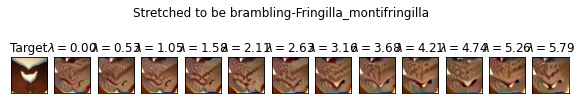

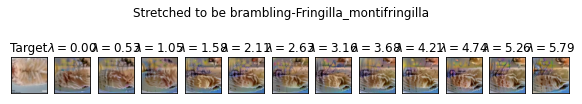

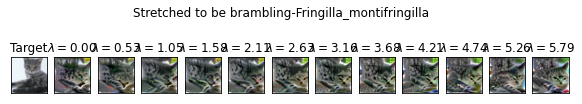

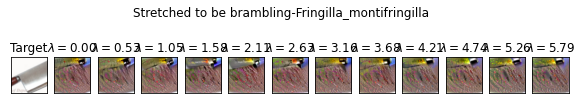

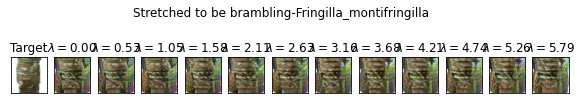

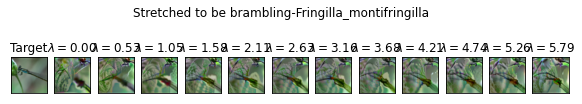

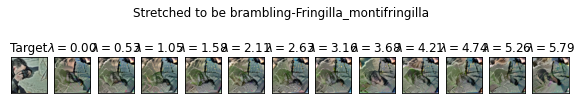

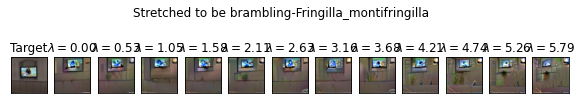

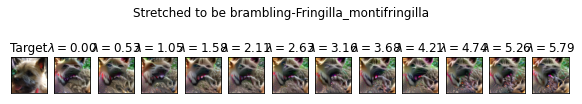

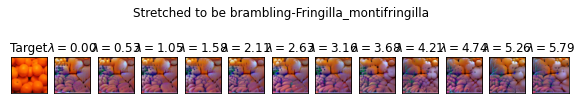

In [94]:
visualize(model1, dataset, inversion_loss, classes_names, vector_class_idx, append_path, num_images=10)